# Test

In [ ]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
from pingouin import ancova
from statsmodels.stats.power import TTestIndPower
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
loc = "Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv"

In [ ]:
data = pd.read_csv(loc)
data.columns

Index(['Arrest_Year', 'Arrest_Month', 'EventID', 'ArrestID', 'PersonID',
       'Perceived_Race', 'Sex', 'Age_group__at_arrest_',
       'Youth_at_arrest__under_18_years', 'ArrestLocDiv', 'StripSearch',
       'Booked', 'Occurrence_Category', 'Actions_at_arrest___Concealed_i',
       'Actions_at_arrest___Combative__', 'Actions_at_arrest___Resisted__d',
       'Actions_at_arrest___Mental_inst', 'Actions_at_arrest___Assaulted_o',
       'Actions_at_arrest___Cooperative', 'SearchReason_CauseInjury',
       'SearchReason_AssistEscape', 'SearchReason_PossessWeapons',
       'SearchReason_PossessEvidence', 'ItemsFound', 'ObjectId'],
      dtype='object')

In [ ]:
# Research Question 1
# Is there a significant interaction effect of gender and the number of arrests, 
# while controlling for race and age group?
data_1 = data[['Perceived_Race', 'Sex', 'Age_group__at_arrest_', 'ArrestLocDiv','StripSearch']]
data_1 = data_1.dropna()
data_1 = data_1[data_1['Sex'] != 'U']
data_1['Age_group__at_arrest_'] = data_1['Age_group__at_arrest_'].replace('Aged 17 years and under', 'Aged 17 years and younger')
data_1['Age_group__at_arrest_'] = data_1['Age_group__at_arrest_'].replace('Aged 65 and older', 'Aged 65 years and older')

In [ ]:
data_1_race = data_1.groupby(['Perceived_Race', 'ArrestLocDiv'])
data_1_race_counts = data_1_race['StripSearch'].agg(['count', 'sum'])
data_1_race_rate = data_1_race_counts['sum'] / data_1_race_counts['count']
data_1_age = data_1.groupby(['Age_group__at_arrest_', 'ArrestLocDiv'])
data_1_age_counts = data_1_age['StripSearch'].agg(['count', 'sum'])
data_1_age_rate = data_1_age_counts['sum'] / data_1_age_counts['count']
data_1_new = pd.DataFrame()
data_1_new["Sex"] = data_1["Sex"]
data_1_new["ArrestLocDiv"] = data_1["ArrestLocDiv"]
data_1_new["Perceived_Race"] = data_1["Perceived_Race"]
data_1_new["Age_group__at_arrest_"] = data_1["Age_group__at_arrest_"]

# Assign corresponding values from data2_race_rate
data_1_new["Perceived_Race"] = [data_1_race_rate[(race, loc)] for race, loc in zip(data_1["Perceived_Race"], data_1["ArrestLocDiv"])]

# Assign corresponding values from data2_sex_rate
data_1_new["Age_group__at_arrest_"] = [data_1_age_rate[(age, loc)] for age, loc in zip(data_1["Age_group__at_arrest_"], data_1["ArrestLocDiv"])]
data_1_new = data_1_new[['Perceived_Race', 'Sex', 'Age_group__at_arrest_']]
data_1 = data_1_new.groupby(['Perceived_Race', 'Sex', 'Age_group__at_arrest_']).size().reset_index(name='counts')
data_1

,Perceived_Race,Sex,Age_group__at_arrest_,counts
0,0.000000,F,0.044444,1
1,0.000000,F,0.093023,1
2,0.000000,F,0.098901,1
3,0.000000,F,0.107345,1
4,0.000000,F,0.119718,1
...,...,...,...,...
1621,0.365854,F,0.259887,1
1622,0.365854,M,0.111732,7
1623,0.365854,M,0.223709,12
1624,0.365854,M,0.259887,3


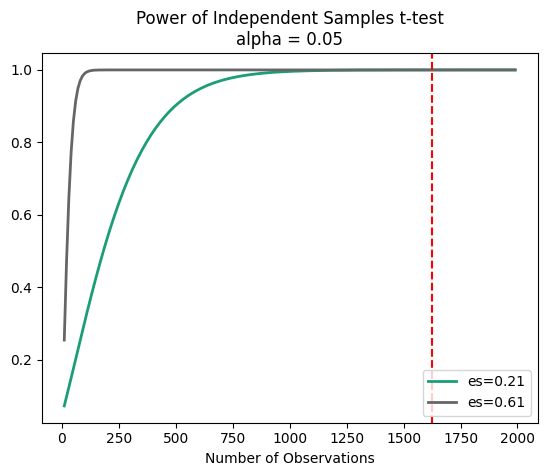

In [ ]:
male_data = data_1[data_1['Sex'] == 'M']
female_data = data_1[data_1['Sex'] == 'F']
mean_male = np.mean(male_data["counts"])
mean_female = np.mean(female_data["counts"])
difference = abs(mean_male - mean_female)
male_count_std = male_data['counts'].std()
female_count_std = female_data['counts'].std()
effect_sizes = np.array([difference/male_count_std, difference/female_count_std])
sample_sizes = np.array(range(10, 2000, 10))
# plot the power test, the dotted red line is our sample size
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
power_analysis = TTestIndPower()
fig = power_analysis.plot_power(
    dep_var='nobs', nobs=sample_sizes,  
    effect_size=effect_sizes, alpha=0.05, ax=ax, 
    title='Power of Independent Samples t-test\nalpha = 0.05')
ax.axvline(x=len(data_1), color='r', linestyle='--')

The sample can be considered large enough for both effect size(calculate from standarad deviation of male and female)

In [ ]:
male_race = male_data['Perceived_Race']
female_race = female_data['Perceived_Race']
t, p = stats.ttest_ind(male_race, female_race)
print(f"T-test for Perceived_Race: t = {t}, p-value = {p}")
# The t-test on the Perceived_Race variable with respect to gender showed 
# that there is no significant difference in perceived race between males and females,
# with a p-value of 0.362. The negative t-value indicates that the mean perceived race 
# for males is lower than the mean perceived race for females, but this difference is
# not statistically significant. Therefore, we fail to reject the null hypothesis and 
# conclude that there is insufficient evidence to suggest that there is a significant 
# difference in perceived race between males and females.

T-test for Perceived_Race: t = -0.9122764826416678, p-value = 0.3617585920098436


In [ ]:
male_age = male_data['Age_group__at_arrest_']
female_age = female_data['Age_group__at_arrest_']
t, p = stats.ttest_ind(male_age, female_age)
print(f"T-test for Age_group__at_arrest_: t = {t}, p-value = {p}")

T-test for Age_group__at_arrest_: t = -1.78016927736456, p-value = 0.07523518528766061


In [ ]:
#test for normality
stat, p = shapiro(data_1["counts"])
print('stat=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

stat=0.222, p=0.000
Sample does not look Gaussian (reject H0)


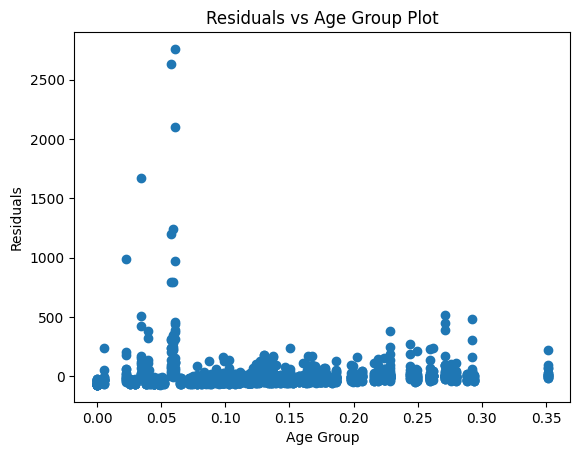

In [ ]:
# Constant check for Age_group__at_arrest_
# fit an ANCOVA model
model = sm.formula.ols('counts ~ Perceived_Race + Sex + Age_group__at_arrest_', data=data_1).fit()

# check for constant variance assumption
residuals = model.resid
fig, ax = plt.subplots()
ax.scatter(data_1['Age_group__at_arrest_'], residuals)
ax.set_xlabel('Age Group')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs Age Group Plot')
plt.show()

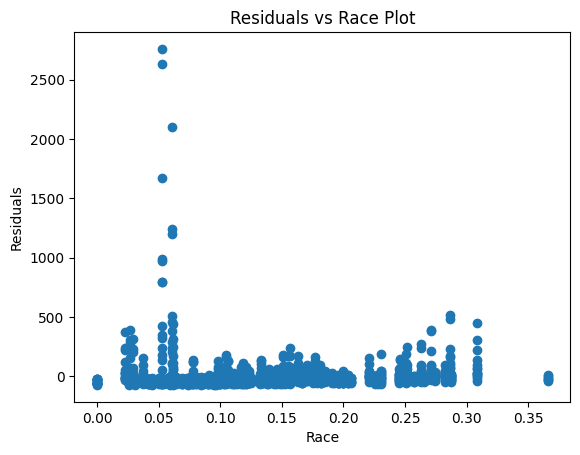

In [ ]:
# Constant check for Age_group__at_arrest_
fig, ax = plt.subplots()
ax.scatter(data_1['Perceived_Race'], residuals)
ax.set_xlabel('Race')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs Race Plot')
plt.show()

In [ ]:
# The variance seems to be constant for most of the time but they have some excpetions around 0.05 for both of the covariate. 
# Therefore the assumpiton of variance is not met.

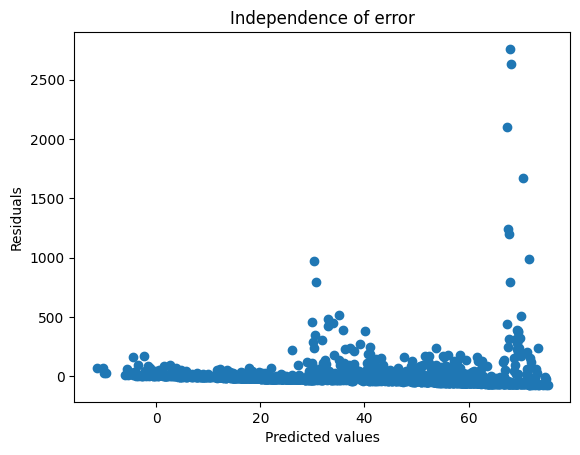

In [ ]:
#check for Independence of error:
# Fit a linear regression model
plt.scatter(model.predict(), residuals)
plt.title('Independence of error')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

In [ ]:
# There is a slightly descending trend of the plot, the assumption of independence of error is not perfectly met, 
# but the pattern is not significant, thus we can still conduct our ancova.

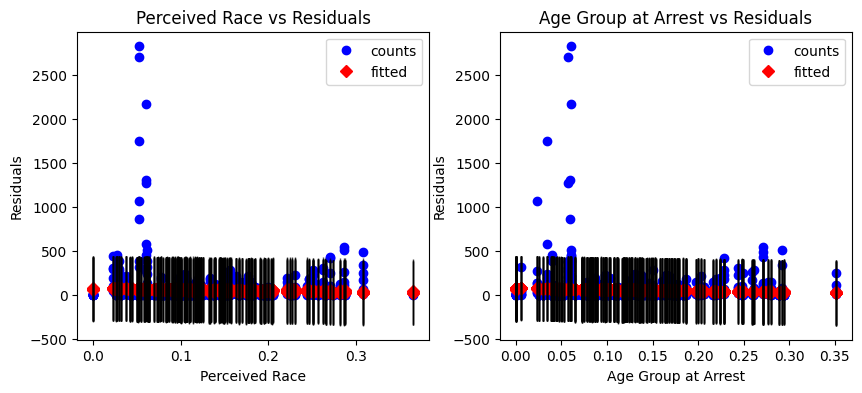

In [ ]:
# fit the model
model = sm.formula.ols('counts ~ Perceived_Race+ Age_group__at_arrest_', data=male_data).fit()

# plot the residuals against each independent variable
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sm.graphics.plot_fit(model, 1, ax=ax[0])
sm.graphics.plot_fit(model, 2, ax=ax[1])
ax[0].set_ylabel('Residuals')
ax[1].set_ylabel('Residuals')
ax[0].set_xlabel('Perceived Race')
ax[1].set_xlabel('Age Group at Arrest')
ax[0].set_title('Perceived Race vs Residuals')
ax[1].set_title('Age Group at Arrest vs Residuals')
plt.show()

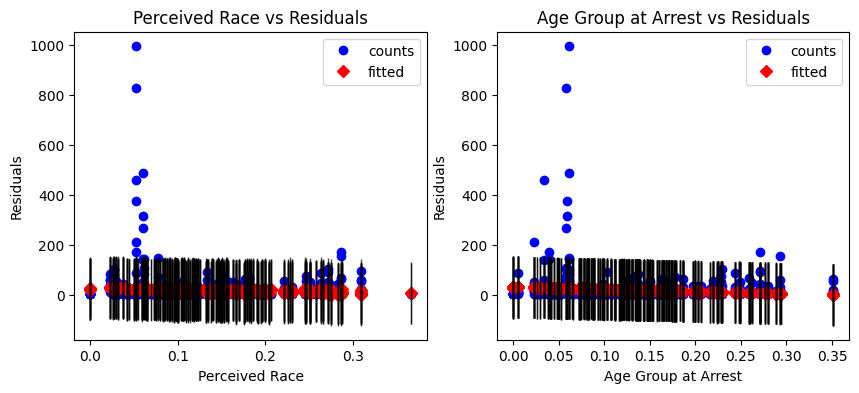

In [ ]:
# fit the model
model = sm.formula.ols('counts ~ Perceived_Race+ Age_group__at_arrest_', data=female_data).fit()

# plot the residuals against each independent variable
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sm.graphics.plot_fit(model, 1, ax=ax[0])
sm.graphics.plot_fit(model, 2, ax=ax[1])
ax[0].set_ylabel('Residuals')
ax[1].set_ylabel('Residuals')
ax[0].set_xlabel('Perceived Race')
ax[1].set_xlabel('Age Group at Arrest')
ax[0].set_title('Perceived Race vs Residuals')
ax[1].set_title('Age Group at Arrest vs Residuals')
plt.show()

In [ ]:
# perform ancova test
ancova(data=data_1, dv='counts', covar=['Perceived_Race',  'Age_group__at_arrest_'], between='Sex')

,Source,SS,DF,F,p-unc,np2
0,Sex,5.580529e+05,1,26.063386,3.693409e-07,0.015815
1,Perceived_Race,1.568199e+04,1,0.732414,3.922283e-01,0.000451
2,Age_group__at_arrest_,6.198837e+04,1,2.895114,8.904015e-02,0.001782
3,Residual,3.472925e+07,1622,NaN,NaN,NaN


In [ ]:
# Research Question 2
# What is the relationship between the strip search rates of an individual's gender and 
# race in the corresponding region
# and the likelihood of being strip-searched during an arrest?
data_2 = data[['Perceived_Race', 'Sex', 'ArrestLocDiv','StripSearch']]
data_2 = data_2.dropna()
data_2 = data_2.drop(data_2[data_2['Sex'] == 'U'].index)
data_2

,Perceived_Race,Sex,ArrestLocDiv,StripSearch
0,White,M,54,0
1,White,M,54,0
2,Unknown or Legacy,M,54,0
3,Black,M,XX,0
4,South Asian,M,XX,0
...,...,...,...,...
65271,Indigenous,F,XX,0
65272,South Asian,M,54,0
65273,White,F,XX,0
65274,Unknown or Legacy,M,XX,0


In [ ]:
# find dependent variable for this data
# i.e. region's stripsearch rate of the individual's gender, sex and the multiplication of gender and sex's rate
data2_race = data_2.groupby(['Perceived_Race', 'ArrestLocDiv'])
data2_race_counts = data2_race['StripSearch'].agg(['count', 'sum'])
data2_race_rate = data2_race_counts['sum'] / data2_race_counts['count']
data2_sex = data_2.groupby(['Sex', 'ArrestLocDiv'])
data2_sex_counts = data2_sex['StripSearch'].agg(['count', 'sum'])
data2_sex_rate = data2_sex_counts['sum'] / data2_sex_counts['count']

In [ ]:
# new data frame with independent value replaced by interested value
data2_new = pd.DataFrame()
data2_new["ArrestLocDiv"] = data_2["ArrestLocDiv"]
data2_new["Sex"] = data_2["Sex"]
data2_new["Perceived_Race"] = data_2["Perceived_Race"]
data2_new["StripSearch"] = data_2["StripSearch"]

# Assign corresponding values from data2_race_rate
data2_new["Perceived_Race"] = [data2_race_rate[(race, loc)] for race, loc in zip(data_2["Perceived_Race"], data_2["ArrestLocDiv"])]

# Assign corresponding values from data2_sex_rate
data2_new["Sex"] = [data2_sex_rate[(sex, loc)] for sex, loc in zip(data_2["Sex"], data_2["ArrestLocDiv"])]
data2_new

,ArrestLocDiv,Sex,Perceived_Race,StripSearch
0,54,0.166215,0.180707,0
1,54,0.166215,0.180707,0
2,54,0.166215,0.099174,0
3,XX,0.053621,0.060513,0
4,XX,0.053621,0.022767,0
...,...,...,...,...
65271,XX,0.040504,0.077615,0
65272,54,0.166215,0.093750,0
65273,XX,0.040504,0.052405,0
65274,XX,0.053621,0.061502,0


In [ ]:
# Build the model
X_2 = data2_new[['Sex', 'Perceived_Race']]
y_2 = data2_new['StripSearch']
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=416)
formula = "StripSearch ~ Sex + Perceived_Race" 
print("Formula: ", formula, "\n")
trainingdata = pd.concat([X_train,y_train], axis = 1)
testdata = pd.concat([X_test,y_test], axis = 1)
log_reg = smf.logit(formula, data=trainingdata).fit()
log_reg.summary()

Formula:  StripSearch ~ Sex + Perceived_Race 

Optimization terminated successfully.
         Current function value: 0.336965
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            StripSearch   No. Observations:                52210
Model:                          Logit   Df Residuals:                    52207
Method:                           MLE   Df Model:                            2
Date:                Sat, 15 Apr 2023   Pseudo R-squ.:                 0.08221
Time:                        04:59:49   Log-Likelihood:                -17593.
converged:                       True   LL-Null:                       -19169.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.2176      0.030   -107.523      0.000      -3.276      -3.159
Sex                1.1837      0.466      2.538      0.011       0.269       2.098
Perceived_Race     7.4451      0.432     17.245      0.000       6.599       8.291
==================================================================================
"""

In [ ]:
# perform Wald test
wald_test_results = log_reg.wald_test_terms()

# Print results of the Wald test
wald_test_results

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


<class 'statsmodels.stats.contrast.WaldTestResults'>
                                  chi2                  P>chi2  df constraint
Intercept       [[11561.242662189034]]                     0.0              1
Sex              [[6.439915547521424]]    0.011158395109021392              1
Perceived_Race  [[297.39724635099435]]  1.2157151740807706e-66              1

The higher the strip search rates of an individual's gender and 
race in the corresponding region are, the more likely they are going to get strip searched.

In [ ]:
# check absence of multicollinearity
log_model = log_reg.model.exog

# Calculate VIF for each predictor variable
vif = [variance_inflation_factor(log_model, i) for i in range(log_model.shape[1])]

# Print VIF values
print(vif)

[3.326788033211076, 7.372004582596957, 7.372004582596969]


There is a low degree of multicollinearity between the predictor variables in the logistic regression model.

In [ ]:
# accuracy of the model
pred_2 = log_reg.predict(X_test)
# round() rounds to nearest integer;
# 0.5 rounds to 0; 0.501 rounds to 1
prediction_2 = list(map(round, pred_2))
print('\nTest accuracy = ', accuracy_score(y_test, prediction_2))


Test accuracy =  0.8828621772772542


In [ ]:
cm = confusion_matrix(y_test, prediction_2) 
print ("\nConfusion Matrix : \n", cm) 


Confusion Matrix : 
 [[11524     0]
 [ 1529     0]]


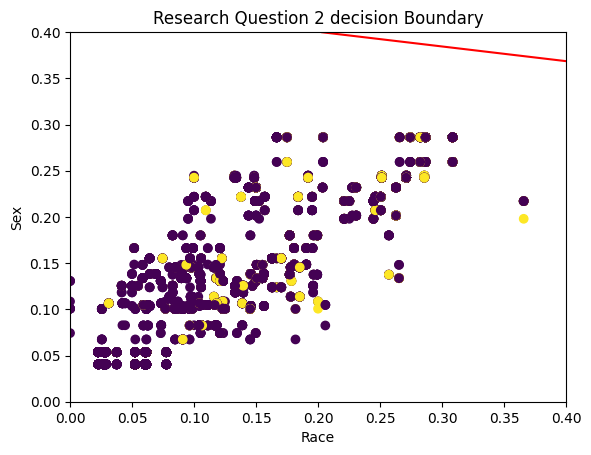

In [ ]:
# Create a grid of points to evaluate the model predictions
plt.scatter(x=X_test["Perceived_Race"], y=X_test["Sex"], c=y_test)
x = np.linspace(0, 0.4, 100)
y = np.linspace(0, 0.4, 100)
X, Y = np.meshgrid(x, y)
Z = log_reg.params[0] + log_reg.params[1] * X + log_reg.params[2] * Y
Z = 1 / (1 + np.exp(-Z))
plt.contour(X, Y, Z, levels=[0.5], colors='red')
plt.title("Research Question 2 decision Boundary")
plt.xlabel("Race")
plt.ylabel("Sex")
plt.show()

CI

In [ ]:
params = log_reg.params
conf = log_reg.conf_int()
conf['OR'] = params
conf.columns = ["Lower CI", "Upper CI", "OR"]
conf

,Lower CI,Upper CI,OR
Intercept,-3.276288,-3.158984,-3.217636
Sex,0.269493,2.098002,1.183747
Perceived_Race,6.598949,8.291261,7.445105


This is the coefficient of the confidence interval of the logistica regression, but this is not plotted in the graph as the decission boundary for this logsitic model is meaningless.

PI

In [ ]:
log_model2 = sm.Logit.from_formula('StripSearch ~ Perceived_Race', trainingdata)
res = log_model2.fit()
me = res.get_margeff()

Optimization terminated successfully.
         Current function value: 0.337025
         Iterations 7


In [ ]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            StripSearch   No. Observations:                52210
Model:                          Logit   Df Residuals:                    52208
Method:                           MLE   Df Model:                            1
Date:                Sat, 15 Apr 2023   Pseudo R-squ.:                 0.08204
Time:                        04:59:52   Log-Likelihood:                -17596.
converged:                       True   LL-Null:                       -19169.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.1980      0.029   -110.969      0.000      -3.254      -3.142
Perceived_Race     8.4715      0.152     55.633      0.000       8.173       8.770
==================================================================================
"""

In [ ]:
me.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            StripSearch
Method:                          dydx
At:                           overall
==================================================================================
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Perceived_Race     0.8331      0.015     56.206      0.000       0.804       0.862
==================================================================================
"""

In [ ]:
Λ = lambda x: stats.logistic().cdf(x)
λ = lambda x: stats.logistic().pdf(x)

β_ = res.params.values.reshape(-1, 1)
V_ = res.cov_params().values

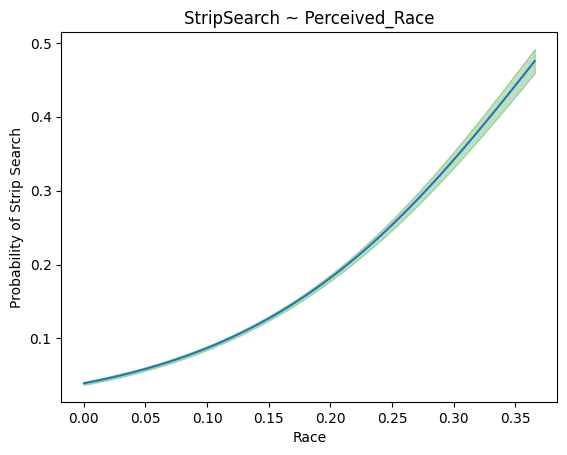

In [ ]:
def var_π(x, β, V_):
    #      λ(z)**s * x.T @ V_ @ x
    prob = λ(x.T.dot(β))**2 * x.T.dot(V_).dot(x)  # maybe this is it?
    return prob


def var_πs(xx, β, V_):
    α = λ(xx.dot(β))**2
    out = np.empty((500, 1))
    for i, x in enumerate(xx):
        out[i] = x.T.dot(V_).dot(x)
    return α * out

xx = sm.add_constant(np.linspace(testdata.Perceived_Race.min(), 
                                 testdata.Perceived_Race.max(), 500).reshape(-1, 1))
πs = Λ(xx.dot(β_))
vv = np.sqrt(var_πs(xx, β_, V_))

plt.plot(xx[:, 1], πs)
plt.fill_between(xx[:, 1], (πs - 1.96*vv).ravel(), (πs + 1.96*vv).ravel(),
                 alpha=.25, color='g')
plt.title("StripSearch ~ Perceived_Race")
plt.xlabel("Race")
plt.ylabel("Probability of Strip Search")
plt.show()

As the logistic model for research question 2 has two independent numerical variable, it is impossible to plot the prediction interval in a 2-D graph. This graph shows the plot for 'StripSearch ~ Perceived_Race', which is the logistic regression for independent variable of research question 2 and one of the dependent variables in RQ2. The green part of the graph shows the 95% confidence interval of the probability of being strip search.

In [ ]:
## Result for question 2, there is no significant relationship between the rate and the likelihood of stripsearch as the data is highly mixed.
## Introducing more independet variable may cause overfitting.
## indicating that toronto police does not do strip research based on the gender or race of assert.

## since 这个模型没有意义，数据分割没有意义，所以没有画pi和ci

In [ ]:
# Another Research Question 2
# What is the relationship between the strip search rates of an individual's Occurrence Category, 
# Cooperative action in the corresponding region
# and the likelihood of being strip-searched during an arrest?

In [ ]:
data_2 = data[['Occurrence_Category', 'Actions_at_arrest___Cooperative', 'ArrestLocDiv','StripSearch']]
data_2 = data_2.dropna()
data_2

,Occurrence_Category,Actions_at_arrest___Cooperative,ArrestLocDiv,StripSearch
0,Assault & Other crimes against persons,1,54,0
1,Assault & Other crimes against persons,0,54,0
2,Assault & Other crimes against persons,0,54,0
3,Harassment/Threatening,0,XX,0
4,FTA/FTC/Compliance Check/Parollee,0,XX,0
...,...,...,...,...
65271,Vehicle Related,0,XX,0
65272,Assault,0,54,0
65273,Assault,0,XX,0
65274,Robbery/Theft,1,XX,0


In [ ]:
data_2['Occurrence_Category'].unique()

array(['Assault & Other crimes against persons', 'Harassment/Threatening',
       'FTA/FTC/Compliance Check/Parollee', 'Assault', 'Robbery/Theft',
       'Sexual Related Crime', 'Mischief & Fraud', 'Warrant',
       'Police Category - Administrative', 'Robbery & Theft',
       'FTA/FTC, Compliance Check & Parollee', 'Drug Related', 'Weapons',
       'Vehicle Related (inc. Impaired)', 'Other Offence',
       'Harassment & Threatening', 'Weapons & Homicide',
       'Break and Enter', 'Mischief', 'Break & Enter',
       'Sexual Related Crimes & Crimes Against Children',
       'Crimes against Children', 'Police Category - Incident', 'Fraud',
       'LLA', 'Mental Health', 'Other Statute', 'Vehicle Related',
       'Other Statute & Other Incident Type', 'Impaired', 'Homicide'],
      dtype=object)

In [ ]:
len(data_2['Occurrence_Category'].unique())

31

In [ ]:
data2_cat = data_2.groupby(['Occurrence_Category', 'ArrestLocDiv'])
data2_cat_counts = data2_cat['StripSearch'].agg(['count', 'sum'])
data2_cat_rate = data2_cat_counts['sum'] / data2_cat_counts['count']
data2_coop = data_2.groupby(['Actions_at_arrest___Cooperative', 'ArrestLocDiv'])
data2_coop_counts = data2_coop['StripSearch'].agg(['count', 'sum'])
data2_coop_rate = data2_coop_counts['sum'] / data2_coop_counts['count']

In [ ]:
data2_new = pd.DataFrame()
data2_new["ArrestLocDiv"] = data_2["ArrestLocDiv"]
data2_new["Occurrence_Category"] = data_2["Occurrence_Category"]
data2_new["Actions_at_arrest___Cooperative"] = data_2["Actions_at_arrest___Cooperative"]
data2_new["StripSearch"] = data_2["StripSearch"]

# Assign corresponding values from data2_race_rate
data2_new["Occurrence_Category"] = [data2_cat_rate[(cat, loc)] for cat, loc in zip(data_2["Occurrence_Category"], data_2["ArrestLocDiv"])]

# Assign corresponding values from data2_sex_rate
data2_new["Actions_at_arrest___Cooperative"] = [data2_coop_rate[(coop, loc)] for coop, loc in zip(data_2["Actions_at_arrest___Cooperative"], data_2["ArrestLocDiv"])]

In [ ]:
data2_new

,ArrestLocDiv,Occurrence_Category,Actions_at_arrest___Cooperative,StripSearch
0,54,0.236715,0.150000,0
1,54,0.236715,0.171569,0
2,54,0.236715,0.171569,0
3,XX,0.008791,0.064756,0
4,XX,0.012152,0.064756,0
...,...,...,...,...
65271,XX,0.000000,0.064756,0
65272,54,0.004762,0.171569,0
65273,XX,0.007021,0.064756,0
65274,XX,0.007457,0.032942,0


In [ ]:
# Build the model
X_2 = data2_new[['Occurrence_Category', 'Actions_at_arrest___Cooperative']]
y_2 = data2_new['StripSearch']
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=416)
formula = "StripSearch ~ Occurrence_Category + Actions_at_arrest___Cooperative" 
print("Formula: ", formula, "\n")
trainingdata = pd.concat([X_train,y_train], axis = 1)
testdata = pd.concat([X_test,y_test], axis = 1)
log_reg = smf.logit(formula, data=trainingdata).fit()
log_reg.summary()

Formula:  StripSearch ~ Occurrence_Category + Actions_at_arrest___Cooperative 

Optimization terminated successfully.
         Current function value: 0.273331
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            StripSearch   No. Observations:                52088
Model:                          Logit   Df Residuals:                    52085
Method:                           MLE   Df Model:                            2
Date:                Sat, 15 Apr 2023   Pseudo R-squ.:                  0.2580
Time:                        05:00:02   Log-Likelihood:                -14237.
converged:                       True   LL-Null:                       -19187.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -3.2999      0.032   -102.852      0.000      -3.363      -3.237
Occurrence_Category                 7.5449      0.107     70.465      0.000       7.335       7.755
Actions_at_arrest___Cooperative    -0.8907      0.244     -3.645      0.000      -1.370      -0.412
===================================================================================================
"""

In [ ]:
# perform Wald test
wald_test_results = log_reg.wald_test_terms()

# Print results of the Wald test
wald_test_results

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


<class 'statsmodels.stats.contrast.WaldTestResults'>
                                                   chi2                  P>chi2  df constraint
Intercept                        [[10578.609343208467]]                     0.0              1
Occurrence_Category               [[4965.300614417732]]                     0.0              1
Actions_at_arrest___Cooperative  [[13.288648193265246]]  0.00026701793821846644              1

The results show that both variables (Intercept, Occurrence_Category, Actions_at_arrest___Cooperative have a significant impact on the likelihood of being searched during the arrest, as indicated by the chi-square test and associated p-values.

In [ ]:
# check absence of multicollinearity
log_model = log_reg.model.exog

# Calculate VIF for each predictor variable
vif = [variance_inflation_factor(log_model, i) for i in range(log_model.shape[1])]

# Print VIF values
print(vif)

[3.29433168713615, 1.29903692616979, 1.2990369261697936]


There is a low degree of multicollinearity between Occurrence_Category and cooperative in the logistic regression model.
可以被忽略

In [ ]:
# accuracy of the model
pred_2 = log_reg.predict(X_test)
# round() rounds to nearest integer;
# 0.5 rounds to 0; 0.501 rounds to 1
prediction_2 = list(map(round, pred_2))
print('\nTest accuracy = ', accuracy_score(y_test, prediction_2))


Test accuracy =  0.8891960377793136


In [ ]:
cm = confusion_matrix(y_test, prediction_2) 
print ("\nConfusion Matrix : \n", cm) 


Confusion Matrix : 
 [[11156   355]
 [ 1088   424]]


In [ ]:
params = log_reg.params
conf = log_reg.conf_int()
conf['OR'] = params
conf.columns = ["Lower CI", "Upper CI", "OR"]
conf

,Lower CI,Upper CI,OR
Intercept,-3.362757,-3.236991,-3.299874
Occurrence_Category,7.335011,7.754728,7.544869
Actions_at_arrest___Cooperative,-1.369587,-0.411804,-0.890695


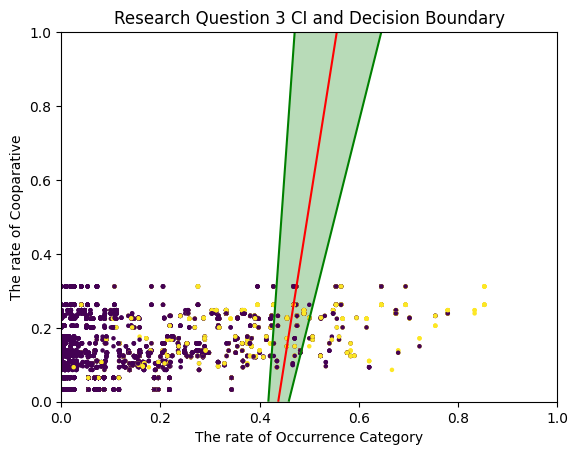

In [ ]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
#decision boundary
Z = log_reg.params[0] + log_reg.params[1] * X + log_reg.params[2] * Y
Z = 1 / (1 + np.exp(-Z))
plt.contour(X, Y, Z, levels=[0.5], colors='red')
# confidence interval
levels = np.linspace(0.4937, 0.5063, 10)
Z_low = conf_lower[0] + conf_lower[1] * X + conf_lower[2] * Y
Z_low = 1 / (1 + np.exp(-Z_low))
plt.contour(X, Y, Z_low, levels=[0.5], colors='green')
Z_up = conf_upper[0] + conf_upper[1] * X + conf_upper[2] * Y
Z_up = 1 / (1 + np.exp(-Z_up))
plt.contour(X, Y, Z_up, levels=[0.5], colors='green')
plt.contourf(X, Y, Z_low, levels=[0, 0.5, 1], colors=['green', 'white'],alpha = 0.15)
plt.contourf(X, Y, Z_up, levels=[0, 0.5, 1], colors=['white', 'green'],alpha = 0.15)
plt.contourf(X, Y, Z_up, levels=[0, 0.5], colors=['white'])
plt.contourf(X, Y, Z_low, levels=[0.5,1], colors=['white'])
plt.scatter(x=X_test["Occurrence_Category"], y=X_test["Actions_at_arrest___Cooperative"], c=y_test,s=5)
plt.title("Research Question 3 CI and Decision Boundary")
plt.xlabel("The rate of Occurrence Category")
plt.ylabel("The rate of Cooparative")
plt.show()

The green region in a logistic regression plot represents the confidence interval for the estimated coefficients. It is bounded by two lines, which correspond to the upper and lower limits of the confidence interval at a specified level of significance, typically 0.975.

In [ ]:
log_model2 = sm.Logit.from_formula('StripSearch ~ Occurrence_Category', trainingdata)
res = log_model2.fit()
me = res.get_margeff()

Optimization terminated successfully.
         Current function value: 0.273460
         Iterations 7


In [ ]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            StripSearch   No. Observations:                52088
Model:                          Logit   Df Residuals:                    52086
Method:                           MLE   Df Model:                            1
Date:                Sat, 15 Apr 2023   Pseudo R-squ.:                  0.2576
Time:                        05:00:04   Log-Likelihood:                -14244.
converged:                       True   LL-Null:                       -19187.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.3729      0.025   -132.613      0.000      -3.423      -3.323
Occurrence_Category     7.2997      0.082     88.933      0.000       7.139       7.461
=======================================================================================
"""

In [ ]:
me.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            StripSearch
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Occurrence_Category     0.5691      0.005    106.437      0.000       0.559       0.580
=======================================================================================
"""

In [ ]:
Λ = lambda x: stats.logistic().cdf(x)
λ = lambda x: stats.logistic().pdf(x)

β_ = res.params.values.reshape(-1, 1)
V_ = res.cov_params().values

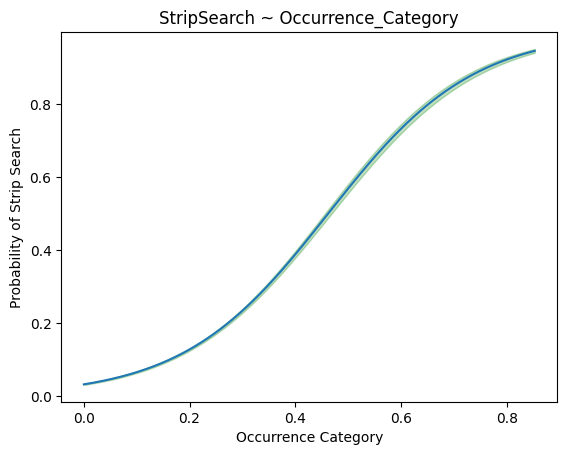

In [ ]:
def var_π(x, β, V_):
    #      λ(z)**s * x.T @ V_ @ x
    prob = λ(x.T.dot(β))**2 * x.T.dot(V_).dot(x)  # maybe this is it?
    return prob


def var_πs(xx, β, V_):
    α = λ(xx.dot(β))**2
    out = np.empty((500, 1))
    for i, x in enumerate(xx):
        out[i] = x.T.dot(V_).dot(x)
    return α * out

xx = sm.add_constant(np.linspace(testdata.Occurrence_Category.min(), 
                                 testdata.Occurrence_Category.max(), 500).reshape(-1, 1))
πs = Λ(xx.dot(β_))
vv = np.sqrt(var_πs(xx, β_, V_))

plt.plot(xx[:, 1], πs)
plt.fill_between(xx[:, 1], (πs - 1.96*vv).ravel(), (πs + 1.96*vv).ravel(),
                 alpha=.25, color='g')
plt.title("StripSearch ~ Occurrence_Category")
plt.xlabel("Occurrence Category")
plt.ylabel("Probability of Strip Search")
plt.show()

As the logistic model for research question 3 has two independent numerical variable, it is impossible to plot the prediction interval in a 2-D graph. This graph shows the plot for 'StripSearch ~ Occurrence_Category', which is the logistic regression for independent variable of research question 3 and one of the dependent variables in RQ3. The green part of the graph shows the 95% confidence interval of the probability of being strip search.

# EDA


In [ ]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
loc = "Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv"

In [ ]:
data = pd.read_csv(loc)
ArrestLocDiv_list = data.ArrestLocDiv.unique()
data_column = data.columns
data_column

Index(['Arrest_Year', 'Arrest_Month', 'EventID', 'ArrestID', 'PersonID',
       'Perceived_Race', 'Sex', 'Age_group__at_arrest_',
       'Youth_at_arrest__under_18_years', 'ArrestLocDiv', 'StripSearch',
       'Booked', 'Occurrence_Category', 'Actions_at_arrest___Concealed_i',
       'Actions_at_arrest___Combative__', 'Actions_at_arrest___Resisted__d',
       'Actions_at_arrest___Mental_inst', 'Actions_at_arrest___Assaulted_o',
       'Actions_at_arrest___Cooperative', 'SearchReason_CauseInjury',
       'SearchReason_AssistEscape', 'SearchReason_PossessWeapons',
       'SearchReason_PossessEvidence', 'ItemsFound', 'ObjectId'],
      dtype='object')

In [ ]:
# Research Question 1
# Is there a significant interaction effect of gender and the number of arrests (dependent variable),
# while controlling for race and age group?

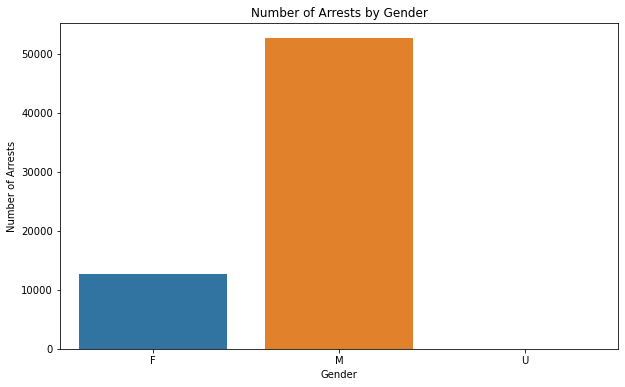

In [ ]:
# gender and the number of arrests

# Create a DataFrame with the count of arrests by gender
gender_arrest_counts = data.groupby(['Sex']).size().reset_index(name='Arrest_Count')

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the bar chart
sns.barplot(x='Sex', y='Arrest_Count', data=gender_arrest_counts, ci=None)
plt.xlabel('Gender')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests by Gender')
plt.show()

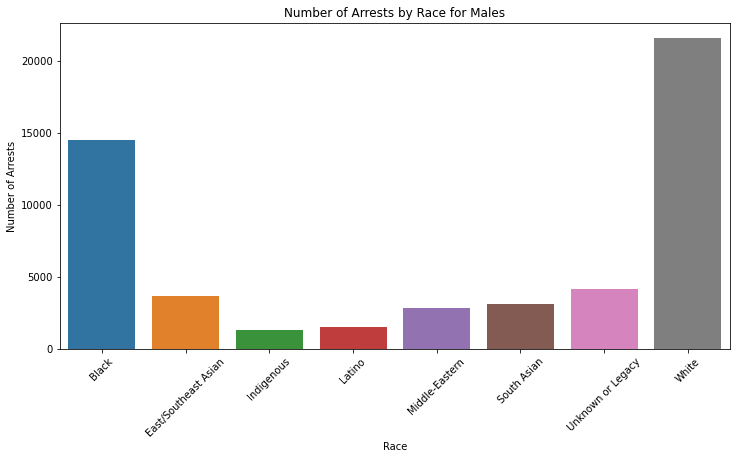

In [ ]:
# Race and the number of arrests (Male)

# Filter the data for males
male_data = data[data['Sex'] == 'M']

# Create a DataFrame with the count of arrests by race for males
male_race_arrest_counts = male_data.groupby(['Perceived_Race']).size().reset_index(name='Arrest_Count')

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the bar chart
sns.barplot(x='Perceived_Race', y='Arrest_Count', data=male_race_arrest_counts, ci=None)
plt.xlabel('Race')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests by Race for Males')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

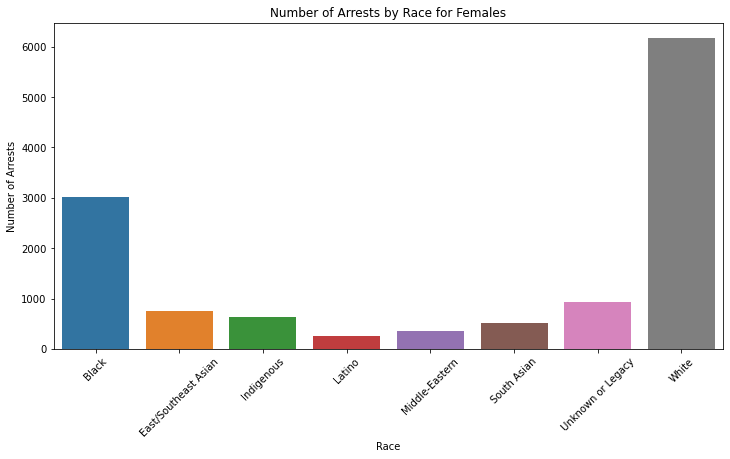

In [ ]:
# Race and the number of arrests (Female)

# Filter the data for males
female_data = data[data['Sex'] == 'F']

# Create a DataFrame with the count of arrests by race for males
female_race_arrest_counts = female_data.groupby(['Perceived_Race']).size().reset_index(name='Arrest_Count')

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the bar chart
sns.barplot(x='Perceived_Race', y='Arrest_Count', data=female_race_arrest_counts, ci=None)
plt.xlabel('Race')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests by Race for Females')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
# Rename 'Aged 17 years and under' to 'Aged 17 years and younger'
data['Age_group__at_arrest_'] = data['Age_group__at_arrest_'].replace('Aged 17 years and under', 'Aged 17 years and younger')
# Rename 'Aged 65 and older' to 'Aged 65 years and older'
data['Age_group__at_arrest_'] = data['Age_group__at_arrest_'].replace('Aged 65 and older', 'Aged 65 years and older')
# Drop NaN
data = data.dropna(subset=['Age_group__at_arrest_'])
data['Age_group__at_arrest_'].unique()

array(['Aged 35 to 44 years', 'Aged 25 to 34 years',
       'Aged 45 to 54 years', 'Aged 55 to 64 years',
       'Aged 18 to 24 years', 'Aged 65 years and older',
       'Aged 17 years and younger'], dtype=object)

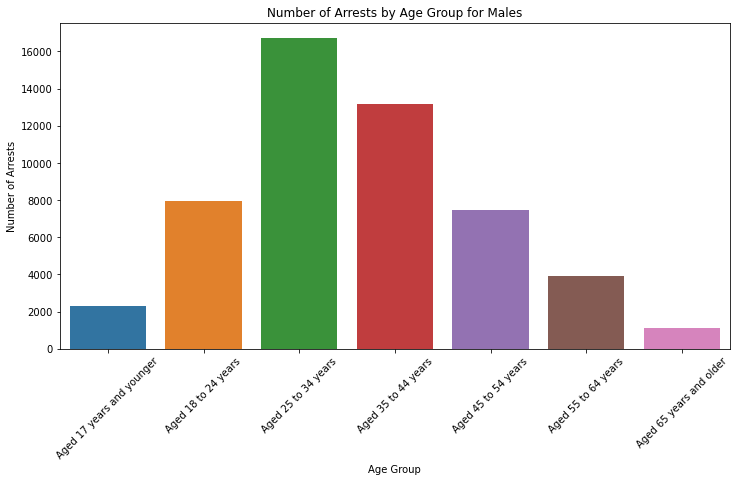

In [ ]:
# Age and the number of arrests (Male)

# Create a DataFrame with the count of arrests by age group for males
male_age_arrest_counts = male_data.groupby(['Age_group__at_arrest_']).size().reset_index(name='Arrest_Count')

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the bar chart
sns.barplot(x='Age_group__at_arrest_', y='Arrest_Count', data=male_age_arrest_counts, ci=None)
plt.xlabel('Age Group')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests by Age Group for Males')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

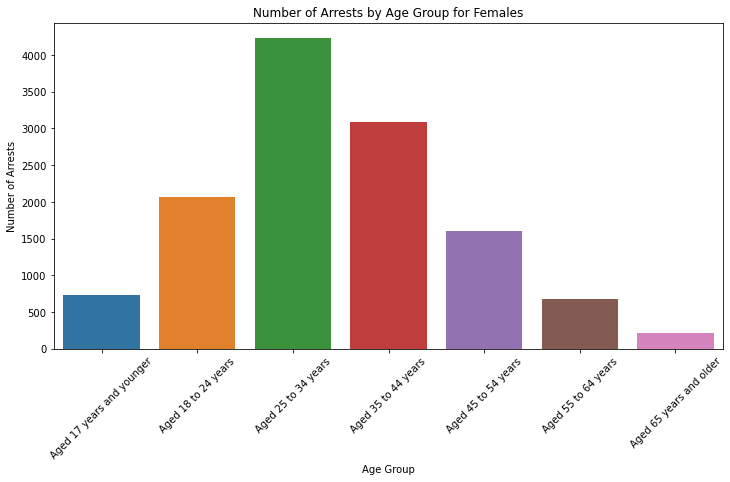

In [ ]:
# Age and the number of arrests (Female)

# Create a DataFrame with the count of arrests by age group for females
female_age_arrest_counts = female_data.groupby(['Age_group__at_arrest_']).size().reset_index(name='Arrest_Count')

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the bar chart
sns.barplot(x='Age_group__at_arrest_', y='Arrest_Count', data=female_age_arrest_counts, ci=None)
plt.xlabel('Age Group')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests by Age Group for Females')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

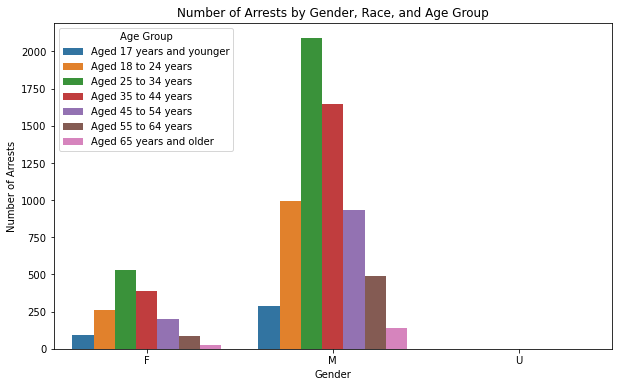

In [ ]:
# Create a DataFrame with the count of arrests by gender, race, and age group
arrest_counts = data.groupby(['Sex', 'Perceived_Race', 'Age_group__at_arrest_']).size().reset_index(name='Arrest_Count')

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the stacked bar chart
sns.barplot(x='Sex', y='Arrest_Count', hue='Age_group__at_arrest_', data=arrest_counts, ci=None)
plt.legend(title='Age Group')
plt.xlabel('Gender')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests by Gender, Race, and Age Group')
plt.show()

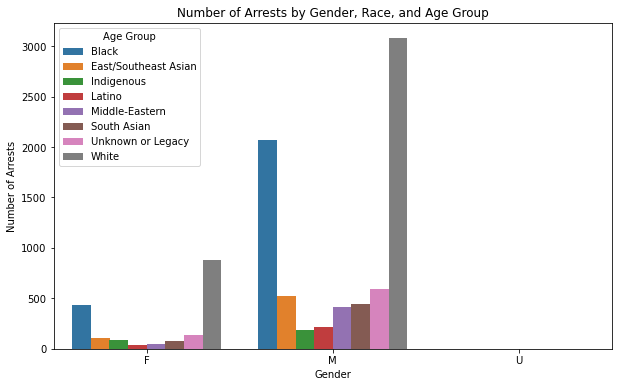

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the stacked bar chart
sns.barplot(x='Sex', y='Arrest_Count', hue='Perceived_Race', data=arrest_counts, ci=None)
plt.legend(title='Age Group')
plt.xlabel('Gender')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests by Gender, Race, and Age Group')
plt.show()

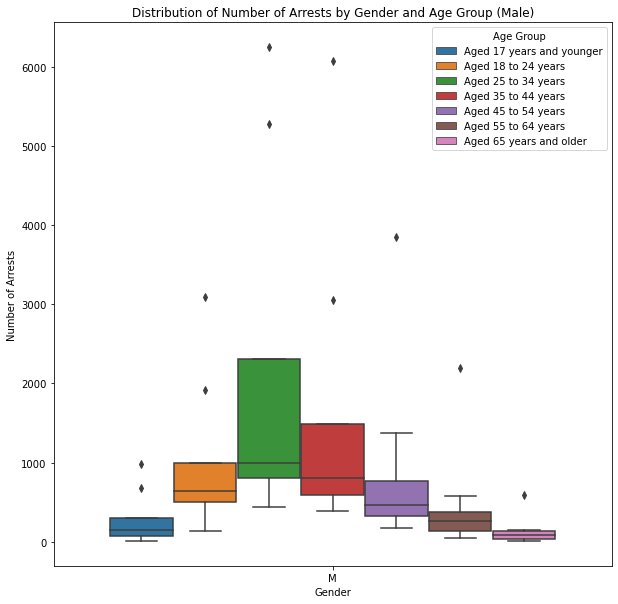

In [ ]:
# Rename 'Aged 17 years and under' to 'Aged 17 years and younger'
male_data = male_data.replace('Aged 17 years and under', 'Aged 17 years and younger')
# Rename 'Aged 65 and older' to 'Aged 65 years and older'
male_data = male_data.replace('Aged 65 and older', 'Aged 65 years and older')

# Create a DataFrame with the count of arrests by gender, race, and age group
arrest_counts = male_data.groupby(['Sex', 'Perceived_Race', 'Age_group__at_arrest_']).size().reset_index(name='Arrest_Count')

plt.figure(figsize=(10, 10))
sns.boxplot(x='Sex', y='Arrest_Count', hue='Age_group__at_arrest_', data=arrest_counts)
plt.xlabel('Gender')
plt.ylabel('Number of Arrests')
plt.title('Distribution of Number of Arrests by Gender and Age Group (Male)')
plt.legend(title='Age Group')
plt.show()

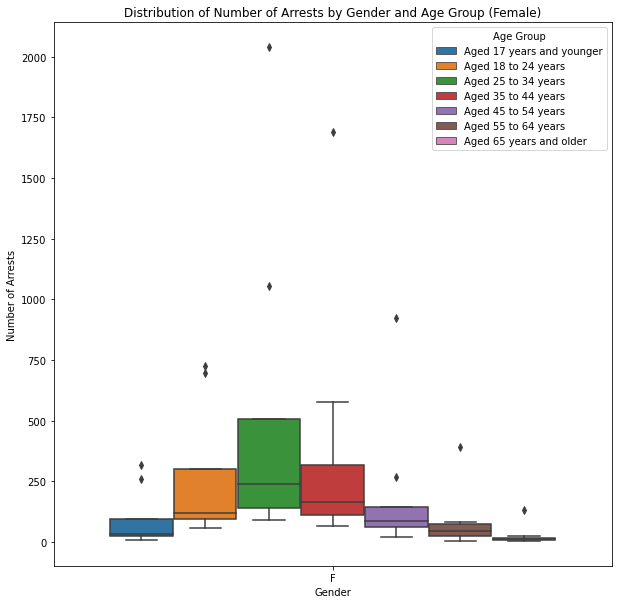

In [ ]:
# Rename 'Aged 17 years and under' to 'Aged 17 years and younger'
female_data = female_data.replace('Aged 17 years and under', 'Aged 17 years and younger')
# Rename 'Aged 65 and older' to 'Aged 65 years and older'
female_data = female_data.replace('Aged 65 and older', 'Aged 65 years and older')

# Create a DataFrame with the count of arrests by gender, race, and age group
arrest_counts_2 = female_data.groupby(['Sex', 'Perceived_Race', 'Age_group__at_arrest_']).size().reset_index(name='Arrest_Count')

plt.figure(figsize=(10, 10))
sns.boxplot(x='Sex', y='Arrest_Count', hue='Age_group__at_arrest_', data=arrest_counts_2)
plt.xlabel('Gender')
plt.ylabel('Number of Arrests')
plt.title('Distribution of Number of Arrests by Gender and Age Group (Female)')
plt.legend(title='Age Group')
plt.show()

In [ ]:
# Research Question 2
# What is the relationship between the strip search rates of an individual's gender 
# and race in the corresponding region and the likelihood of being strip-searched during an arrest?

In [ ]:
# Calculate the total number of arrests and strip searches for each combination of gender, race, and region
arrests_strip_searches = data.groupby(['Sex', 'Perceived_Race', 'ArrestLocDiv']).agg(
    {'ArrestID': 'count', 'StripSearch': 'sum'}
).reset_index().rename(columns={'ArrestID': 'Arrest_Count', 'StripSearch': 'Strip_Search_Count'})

In [ ]:
arrests_strip_searches['Strip_Search_Rate'] = arrests_strip_searches['Strip_Search_Count'] / arrests_strip_searches['Arrest_Count']

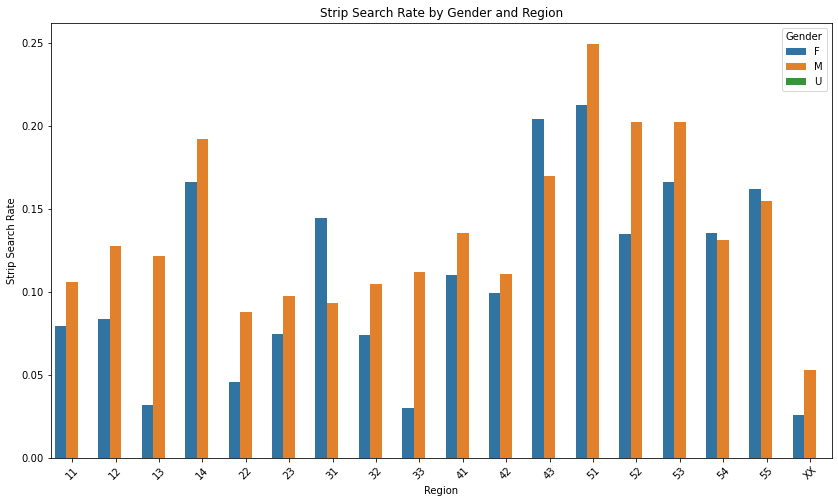

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(x='ArrestLocDiv', y='Strip_Search_Rate', hue='Sex', data=arrests_strip_searches, ci=None)
plt.xlabel('Region')
plt.ylabel('Strip Search Rate')
plt.title('Strip Search Rate by Gender and Region')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.show()

In [ ]:
heatmap_data = arrests_strip_searches.pivot_table(
    index=['ArrestLocDiv', 'Sex'],
    columns='Perceived_Race',
    values='Strip_Search_Rate'
).reset_index().set_index(['ArrestLocDiv', 'Sex'])

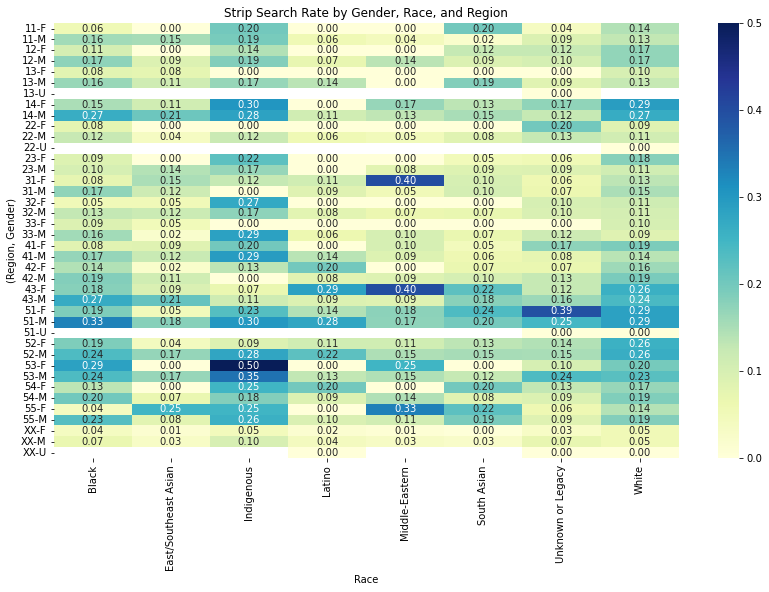

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt='.2f')
plt.xlabel('Race')
plt.ylabel('(Region, Gender)')
plt.title('Strip Search Rate by Gender, Race, and Region')
plt.show()

In [ ]:
# Research Question 3
# What is the relationship between the strip search rates of an individual's criminal occurrence category 
# and cooperative action at arrest in the corresponding region and the likelihood of being strip-searched 
# during an arrest?

In [ ]:
# Calculate the total number of arrests and strip searches for each combination of occurrence category, cooperative action, and region
arrests_strip_searches_occ = data.groupby(['Occurrence_Category', 'Actions_at_arrest___Cooperative', 'ArrestLocDiv']).agg(
    {'ArrestID': 'count', 'StripSearch': 'sum'}
).reset_index().rename(columns={'ArrestID': 'Arrest_Count', 'StripSearch': 'Strip_Search_Count'})

In [ ]:
arrests_strip_searches_occ['Strip_Search_Rate'] = arrests_strip_searches_occ['Strip_Search_Count'] / arrests_strip_searches_occ['Arrest_Count']

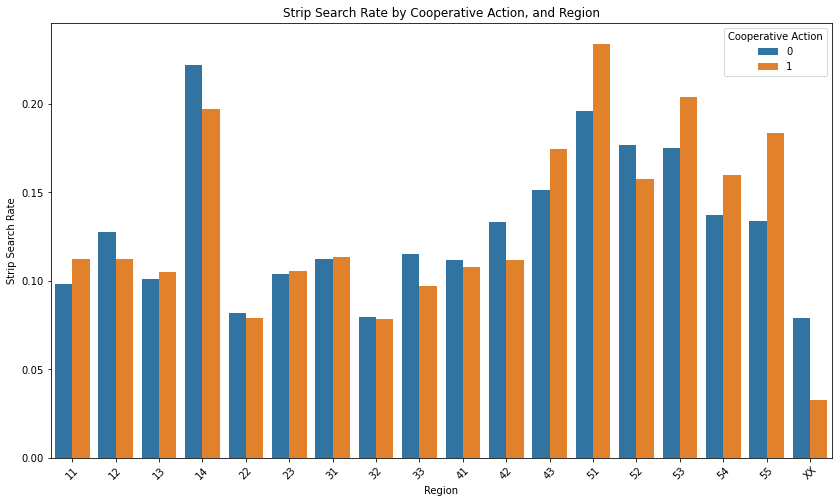

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(x='ArrestLocDiv', y='Strip_Search_Rate', hue='Actions_at_arrest___Cooperative', data=arrests_strip_searches_occ, ci=None)
plt.xlabel('Region')
plt.ylabel('Strip Search Rate')
plt.title('Strip Search Rate by Cooperative Action, and Region')
plt.legend(title='Cooperative Action')
plt.xticks(rotation=45)
plt.show()

In [ ]:
heatmap_data_occ = arrests_strip_searches_occ.pivot_table(
    index=['ArrestLocDiv', 'Actions_at_arrest___Cooperative'],
    columns='Occurrence_Category',
    values='Strip_Search_Rate'
).reset_index().set_index(['ArrestLocDiv', 'Actions_at_arrest___Cooperative'])

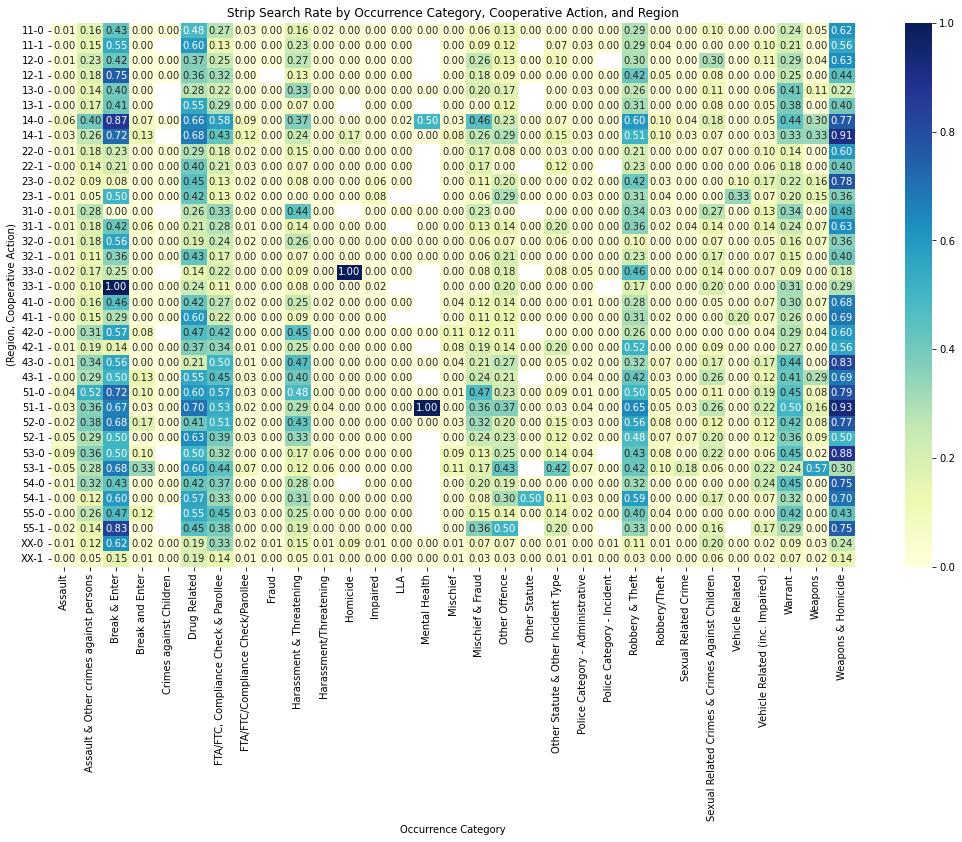

In [ ]:
plt.figure(figsize=(18, 10))
sns.heatmap(heatmap_data_occ, annot=True, cmap="YlGnBu", fmt='.2f')
plt.xlabel('Occurrence Category')
plt.ylabel('(Region, Cooperative Action)')
plt.title('Strip Search Rate by Occurrence Category, Cooperative Action, and Region')
plt.show()